# Device Webpages

We can get each device's homepage from IoTList and try to get some categories that way.

In [459]:
import pickle
with open('amazon_search_results_no-ignore.pickle', 'rb') as f:
    amzn = pickle.load(f)

In [460]:
# Get the editorial review for each object
from bs4 import BeautifulSoup

def strip_html(html):
    text = BeautifulSoup(html).get_text(separator='. ')
    text = text.replace('Product Description', '')
    text = text.replace('.0', '')
    return text+'.'

def get_ed_review(xml):
    html = BeautifulSoup(xml, 'xml').find('EditorialReview').text
    return strip_html(html)#utils.process_html(html)

ed_revs = []
for k,v in amzn.items():
    try:
        ed_revs.insert(0, (k, get_ed_review(v)))
    except Exception as e:
        print('nope')

/home/trevor/miniconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/trevor/miniconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope


In [461]:
# TODO: some summaries (Google home) have multiple sentences, but still
# don't produce any summaries. Why?

import re
import gensim

SUMMARY_LENGTHS = [50, 100, 200, 'FULL']

all_summaries = {k: [] for k in SUMMARY_LENGTHS}

for length, summaries in all_summaries.items():
    for t in ed_revs:
        try:
            if not length == 'FULL':
                summary = gensim.summarization.summarize(
                    t[1], 
                    word_count=length)
            if (length=='FULL' and t[0]) or summary:
                summaries.insert(0, (t[0], (t[1] if length=='FULL' else summary)))
        except ValueError as e:
            print(length, t[0], e)

50 tado°:  The connected heating system  input must have more than one sentence
50 Staples Connect:  Home automation platform input must have more than one sentence
50 Viper:  Home Security Starter Kit input must have more than one sentence
50 UP 24:  Tracking a healthy lifestyle input must have more than one sentence
50 Goldee:  Smart light controller input must have more than one sentence
50 Kiwi:  All-Purpose wearable device  input must have more than one sentence
50 Whistle:  Connected pet collar  input must have more than one sentence
50 WeMo Light Switch:  Control your lights from anywhere  input must have more than one sentence
50 Lockitron:  make your deadbolt wirelessly controlled input must have more than one sentence
50 Logitech Harmony Ultimate:  Connected entertainment hub  input must have more than one sentence
50 Ring:  Wearable input device that lets you control anything input must have more than one sentence
50 Withings:  Smart baby monitor input must have more than on

In [4]:
import utils

p_s = {k: [(n, utils.process_html(s)) for n, s in summaries] 
       for k, summaries in all_summaries.items()}

/home/trevor/miniconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/trevor/miniconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [5]:
flat_er_sums = {k: [] for k in SUMMARY_LENGTHS}
for length, summaries in p_s.items():
    for e in summaries:
        for r in e[1]:
            flat_er_sums[length].insert(0, (e[0], r))

In [6]:
import gensim

NUM_TOPICS = 15

# Perform LDA
all_lda = {}
all_dictionaries = {}
for k, er_sums in flat_er_sums.items():
    all_dictionaries[k] = gensim.corpora.Dictionary([e[1] for e in er_sums])
    corpus = [all_dictionaries[k].doc2bow(s[1]) 
              for s in flat_er_sums[k]]
    all_lda[k] = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS)

In [7]:
for k, lda in all_lda.items():
    print('Summary length = {}'.format(k))
    print()
    for i in range(NUM_TOPICS):
        print('Topic: {}'.format(i))
        print(', '.join([all_dictionaries[k].get(term) for term,_ in lda.get_topic_terms(i)]))
        print()
    print('\n\n\n')

Summary length = 50

Topic: 0
watch, batteri, capac, keep, air, hero, view, well, featur, button

Topic: 1
connect, home, can, devic, smart, turn, kit, ring, world, design

Topic: 2
control, day, sound, allow, power, can, connect, music, show, light

Topic: 3
tv, power, batteri, 3, support, watch, two, hd, bass, wireless

Topic: 4
activ, deliv, devic, track, motion, time, jbl, sleep, sensor, connect

Topic: 5
oil, secur, x, home, support, system, window, pair, make, speaker

Topic: 6
featur, can, fit, devic, design, camera, directli, attach, clip, set

Topic: 7
can, time, input, voltag, power, output, tv, devic, specif, light

Topic: 8
door, sleep, usb, qualiti, 3, even, home, made, includ, interfac

Topic: 9
video, can, clear, alert, sound, keep, cabl, design, superior, stream

Topic: 10
make, app, one, camera, item, home, color, enabl, will, alexa

Topic: 11
qualiti, power, list, technolog, design, home, brand, new, babi, wigwag

Topic: 12
design, offer, mount, can, tilt, qualiti, ho

In [462]:
# TF-IDF (from "Document Clustering with Python")
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.strip() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and token != "'s" and token != 's':
            filtered_tokens.append(token)
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    #stemmer = nltk.stem.porter.PorterStemmer()
    stems = [stemmer.stem(t)
             for t in filtered_tokens]
    return stems

tfidf_vectorizers = {k: TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.1, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem,
                                   ngram_range=(1,2), sublinear_tf=True)
                     for k in SUMMARY_LENGTHS}

tfidf_matrices = {k: tfidf_vectorizers[k].fit_transform([w[1] 
                                                         for w in v]).toarray() 
                  for k,v in all_summaries.items()}

In [465]:
feature_names = {k: tf.get_feature_names() 
                       for k,tf in tfidf_vectorizers.items()}

feature_indices = {k: {doc: tfidf_matrices[k][doc,:].nonzero()[0] 
                             for doc in range(tfidf_matrices[k].shape[0])}
                         for k in SUMMARY_LENGTHS}

tfidf_scores = {k: {doc: zip(ft_ind, [tfidf_matrices[k][doc,x] 
                                      for x in ft_ind])
                    for doc, ft_ind in feature_indices[k].items()}
                for k in SUMMARY_LENGTHS}

In [464]:
### IF YOU RUN THIS CELL, RE-RUN THE ONE ABOVE IT BEFORE RUNNING ###
### OTHER CELLS. The zip will be exhausted after this.           ###

# Nest camera
MAX_WORDS = 100
for i in range(5):
    s = sorted(tfidf_scores[MAX_WORDS][i], key=lambda x: x[1], reverse=True)
    fts = {ft[0]: ft[1] for ft in feature_names.items()}
    print(all_summaries[MAX_WORDS][i][0])
    [print('{:.<20}{:.3f}'.format(fts[MAX_WORDS][j], v)) for j,v in s]
    print()

Nest Thermostat:  E
protect.............0.521
help................0.516
fit.................0.302
turn................0.288
work................0.288
ani.................0.281
new.................0.274
home................0.228

August:  Smart Lock 3rd generation 
smart...............0.430
know................0.250
secur...............0.250
io..................0.247
product.............0.247
android.............0.237
onli................0.237
activ...............0.229
technolog...........0.229
easi................0.225
bluetooth...........0.221
free................0.216
smartphon...........0.216
set.................0.214
home................0.179
control.............0.177
app.................0.158
use.................0.155

Amazon Echo Show:  Alexa with a screen 
amazon..............0.448
video...............0.435
light...............0.368
devic...............0.327
connect.............0.325
home................0.322
app.................0.284
use.................0.279

Awair Glow:  Smar

In [479]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import pandas as pd

MAX_WORDS = 100
NUM_CLUSTERS = 10

df = pd.DataFrame(device_tfidf)

# Clustering algorithm
# K-Means
km = KMeans(n_clusters=NUM_CLUSTERS)
km.fit(tfidf_matrices[MAX_WORDS])
clusters = km.labels_.tolist()
#DBSCAN
db = DBSCAN(eps=1, min_samples=5)
db.fit(tfidf_matrices[MAX_WORDS])
#clusters = db.labels_.tolist()
# Spectral clustering
sc = SpectralClustering(n_clusters=NUM_CLUSTERS)
sc.fit(tfidf_matrices[MAX_WORDS])
#clusters = sc.labels_.tolist()

# Reduce to 2 dimensions
# PCA
pca = PCA(n_components=2)
pca.fit(tfidf_matrices[MAX_WORDS])
#MDS
mds = MDS(n_components=2, random_state=1)
mds_pos = mds.fit_transform(tfidf_matrices[MAX_WORDS])
#xs, ys = mds_pos[:, 0], mds_pos[:, 1]
#T-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=1)
tsne_pos = tsne.fit_transform(tfidf_matrices[MAX_WORDS])
xs, ys = tsne_pos[:, 0], tsne_pos[:, 1]

pre_df = list(zip([name for name,_ in all_summaries[MAX_WORDS]], 
                      xs, ys, clusters))
df = pd.DataFrame(pre_df)
df.columns = ['name', 'x', 'y', 'category']

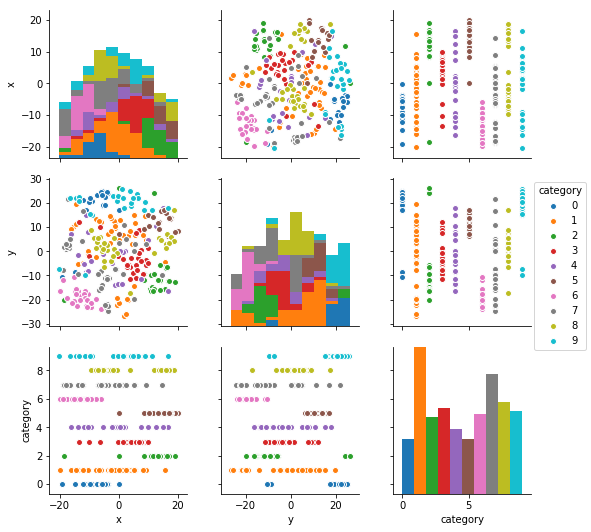

In [480]:
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline

sb.pairplot(data=df, hue='category')

In [481]:
for group in df.groupby('category', as_index=False):
    print('Category {}:'.format(group[0]))
    for name in group[1]['name']:
        print(name)
    print()
    print('================================================')
    print()

Category 0:
Nest Thermostat:  E
CUJO:  Smart firewall for the smart home
Blossom:  Smart watering controller
The Defender:  Smart personal protection
STACK Box:  A smart home controller
Monolyth:  Control your AC with your Smartphone
LILA:  The Ultimate in Bluetooth 4.0 Home Safety & Security
EZTech:  Smartwatch
Healbe GoBe:  Automatically measure calorie intake
Skulpt Aim:  Body composition & muscle quality analyzer
Nest Protect:  Smart Smoke and Carbon Monoxide (CO) Alarm
BluCub:  Bluetooth Humidity & Temperature Sensor
Nest Thermostat:  The learning thermostat 
Melon:  A Headband and Mobile App to Measure Your Focus
Lono:  Sprinkler Controller
Amiigo:  Fitness Bracelet for iPhone and Android 
MEMI:  Wearable tech for women
ION Glasses:  First prescription connected glasses 


Category 1:
Nest Cam:  Outdoor
Starry Station:  WiFi wireless router
Foobot:  Indoor air quality monitor
June:  Intelligent oven
Misfit Wearables:  Shine 2
Google Chromecast:  Second generation 
Nest Cam:  Conn